In [1]:
import numpy as np

def first_visit_monte_carlo(env, policy=None, gamma=1.0, num_episodes=5_000):
    # Initialize the value function randomly.
    V = {state: np.random.rand() for state in env.state_space}

    # Initialize the Reward variable with empty lists for each state.
    rewards = {state: [] for state in env.state_space}

    for _ in range(num_episodes):
        episode = []

        # Generate an episode using the given policy.
        state = env.reset()
        action = policy[state] if policy else env.action_space.sample()
        next_state, reward, terminated  = env.step(action)
        episode.append((state, action, reward))
        while not terminated:
            state = next_state
            action = policy[state] if policy else env.action_space.sample()
            next_state, reward, terminated = env.step(action)
            episode.append((state, action, reward))


        # Initialize the expected return.
        G = 0.0

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma*G + reward
            if state not in [x[0] for x in episode[:t]]:
                rewards[state].append(G)
                V[state] = np.mean(rewards[state])
    return V


In [2]:
from custom_classes import CustomBlackjackEnv

env = CustomBlackjackEnv()

# Compute the value function for the random policy.
V = first_visit_monte_carlo(env, num_episodes=5_000)

# Print the value function for the random policy.
print("--------------- Value Function for Random Policy ----------------")
i = 0
for state, value in V.items():
    if i < 10:
        print(f"V[{state}] = {V[state]}")
    else:
        break
    i += 1

--------------- Value Function for Random Policy ----------------
V[(4, 1, False)] = -1.0
V[(4, 1, True)] = 0.10688956914039194
V[(4, 2, False)] = -0.2857142857142857
V[(4, 2, True)] = 0.45669679308416344
V[(4, 3, False)] = -1.0
V[(4, 3, True)] = 0.7443641608572327
V[(4, 4, False)] = -1.0
V[(4, 4, True)] = 0.14591411797638876
V[(4, 5, False)] = 0.0
V[(4, 5, True)] = 0.5409144927465458


In [3]:

import matplotlib.pyplot as plt

def prepare_data_for_plot(V, usable_ace):
    player_sums = sorted(set(key[0] for key in V.keys() if 12 <= key[0] <= 21 and key[2] == usable_ace))
    dealer_showing = sorted(set(key[1] for key in V.keys() if key[2] == usable_ace))
    Y, X = np.meshgrid(player_sums, dealer_showing)
    Z = np.zeros_like(X, dtype=float)

    # Outer loop for dealer's card.
    for i, dealer_card in enumerate(dealer_showing):
        # Inner loop for player's sum.
        for j, player_sum in enumerate(player_sums):
            # Assign values accordingly.
            Z[i, j] = V.get((player_sum, dealer_card, usable_ace), np.nan)

    return X, Y, Z

def plot_value_function(V, usable_ace, title):
    X, Y, Z = prepare_data_for_plot(V, usable_ace)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Dealer\'s Showing Card')
    ax.set_ylabel('Player\'s Current Sum')
    ax.set_zlabel('Value')
    ax.set_title(title)
    fig.colorbar(surf)
    plt.show()

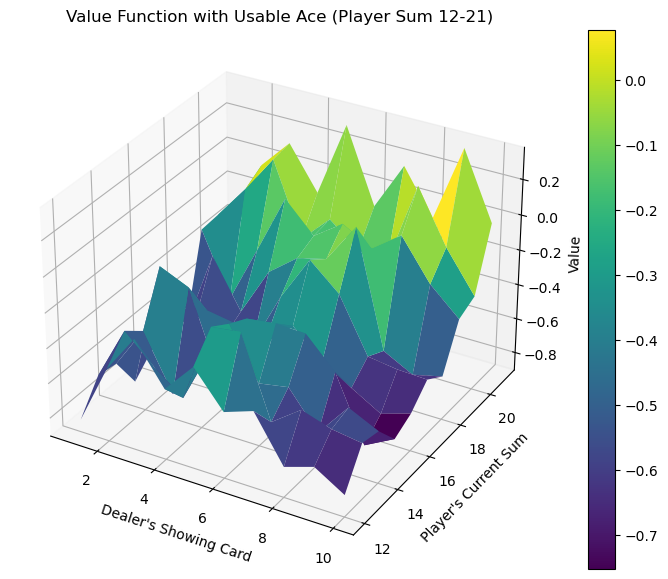

In [4]:
# Plot for states without a usable ace, with axes switched
plot_value_function(V, 0, 'Value Function with Usable Ace (Player Sum 12-21)')

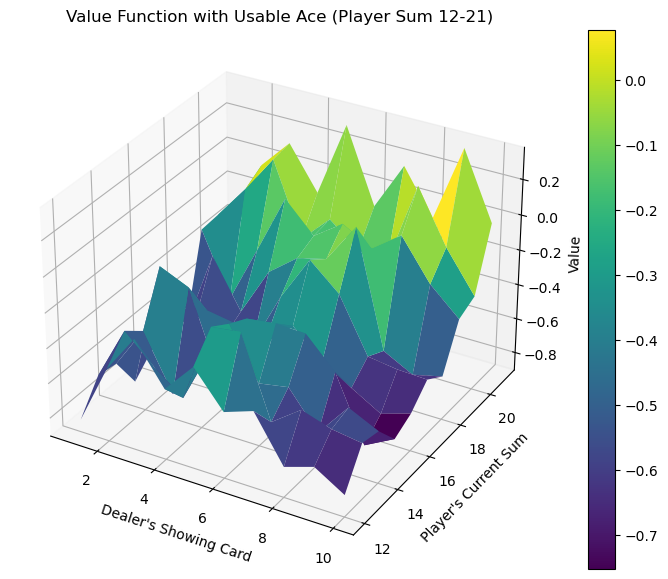

In [5]:
# Plot for states with a usable ace, with axes switched
plot_value_function(V, 0, 'Value Function with Usable Ace (Player Sum 12-21)')

In [6]:
# Sutton & Barto BlackJack policy from the Monte Carlo Chapter.
# sab_policy = {state: int(state[0] < 20) for state in env.state_space}
sab_policy = {state : int(state[0] < 20) for state in env.state_space}

# Compute the value function for the Sutton & Barto policy.
V = first_visit_monte_carlo(env, sab_policy)

# Print the value function for the Sutton & Barto policy.
print("------------- Value Function for Sutton & Barto Policy ----------------")
i = 0
for state, value in V.items():
    if i < 10:
        print(f"V[{state}] = {V[state]}")
    else:
        break
    i += 1

------------- Value Function for Sutton & Barto Policy ----------------
V[(4, 1, False)] = 0.3333333333333333
V[(4, 1, True)] = 0.8221571115413987
V[(4, 2, False)] = -0.6666666666666666
V[(4, 2, True)] = 0.49638581721464314
V[(4, 3, False)] = -1.0
V[(4, 3, True)] = 0.7031522948094441
V[(4, 4, False)] = -0.25
V[(4, 4, True)] = 0.23977142485005765
V[(4, 5, False)] = 0.0
V[(4, 5, True)] = 0.579136140637909


In [7]:
# Compute the value function for the Sutton & Barto policy with 500_000 iterations.
# Note, this will take a few minutes..... Using Chapter 2 for inspiration, can you make this faster?
V = first_visit_monte_carlo(env, sab_policy, num_episodes=30_000)

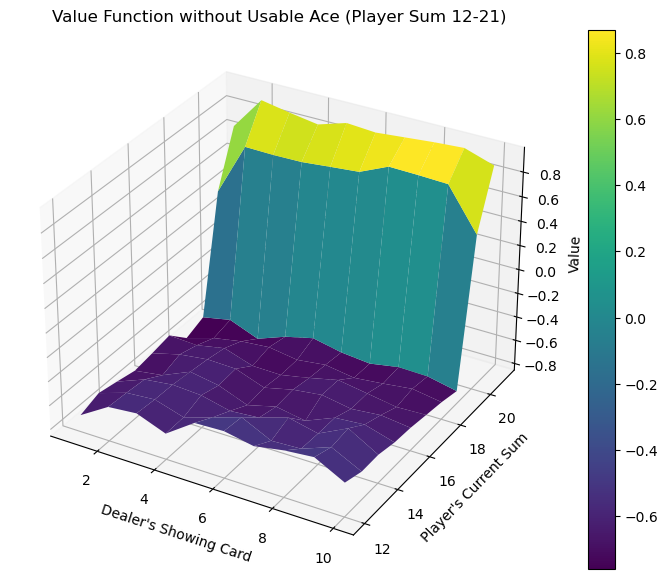

In [8]:
# Plot for states without a usable ace.
plot_value_function(V, 0, 'Value Function without Usable Ace (Player Sum 12-21)')

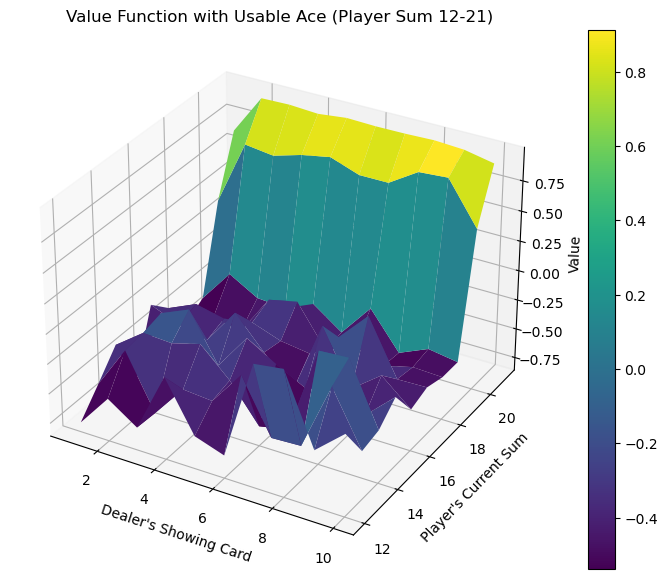

In [9]:
# Plot for states with a usable ace.
plot_value_function(V, 1, 'Value Function with Usable Ace (Player Sum 12-21)')

In [10]:
def prepare_data_for_plot(V, usable_ace):
    player_sums = sorted(set(key[0] for key in V.keys() if 12 <= key[0] <= 21 and key[2] == usable_ace))
    dealer_showing = sorted(set(key[1] for key in V.keys() if key[2] == usable_ace))
    Y, X = np.meshgrid(player_sums, dealer_showing)
    Z = np.zeros_like(X, dtype=float)

    for i, dealer_card in enumerate(dealer_showing):
        for j, player_sum in enumerate(player_sums):
            Z[i, j] = V.get((player_sum, dealer_card, usable_ace), np.nan)

    return X, Y, Z

def plot_value_function_subplot(V_first, V_second, title_first, title_second):
    fig = plt.figure(figsize=(20, 14))

    for i, usable_ace in enumerate([0, 1]):
        X, Y, Z_first = prepare_data_for_plot(V_first, usable_ace)
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z_first, cmap='viridis', edgecolor='none')
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Current Sum")
        ax.set_zlabel('Value')
        ax.set_title(f"{title_first} - Usable Ace: {bool(usable_ace)}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        X, Y, Z_second = prepare_data_for_plot(V_second, usable_ace)
        ax = fig.add_subplot(2, 2, i + 3, projection='3d')
        surf = ax.plot_surface(X, Y, Z_second, cmap='viridis', edgecolor='none')
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Current Sum")
        ax.set_zlabel('Value')
        ax.set_title(f"{title_second} - Usable Ace: {bool(usable_ace)}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

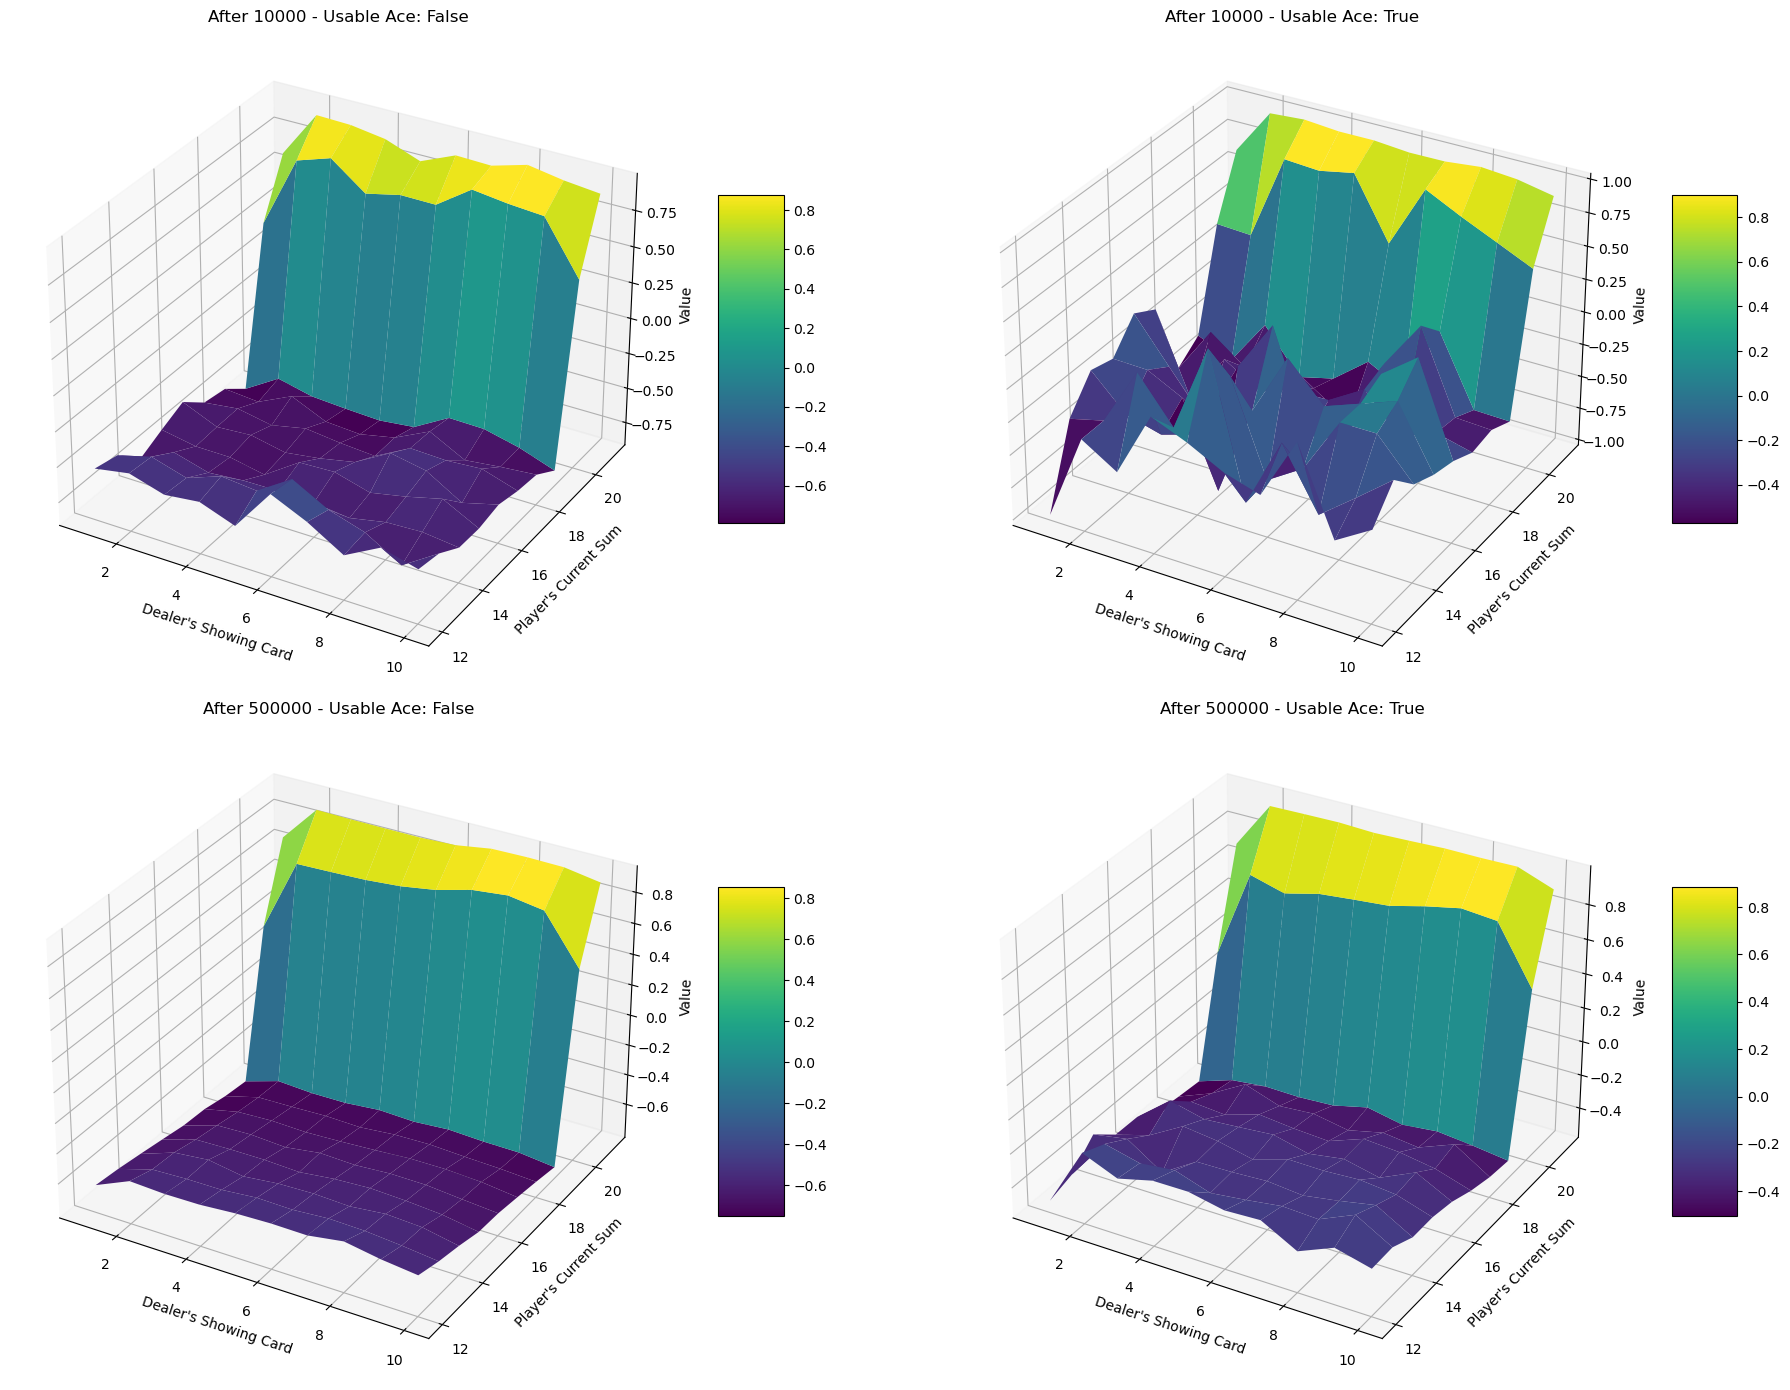

In [11]:
first_num_episodes = 10_000
second_num_episodes = 500_000

# Generate Figure 5.1 from Sutton & Barto's book.
V_first = first_visit_monte_carlo(env, sab_policy, num_episodes=first_num_episodes)
V_second = first_visit_monte_carlo(env, sab_policy, num_episodes=second_num_episodes)

plot_value_function_subplot(V_first, V_second, f'After {first_num_episodes}', f'After {second_num_episodes}')